### Franck-Hertz Lab - Data & Results

This notebook includes all data processing, graphs, and final calculations for the Franck-Hertz Lab. 

#### Part 0 - Useful Libraries and Functions

This section contains libraries and functions that coud potentially be used later.

In [1571]:
import matplotlib.pyplot as plt #useful libraries
import math
from uncertainties import ufloat, umath, unumpy
import numpy as np
import pandas as pd

planck_const = 6.62607015*(10**(-34)) #useful physical constants
speed_light = 299792458
ev_to_joules = 1.602 * (10**(-19))

In [1572]:
def compute_line_fit(xs, ys): #Function to compute line fit
    xs, xerror = np.array([x.n for x in xs]), np.array([x.s for x in xs])
    ys, yerror = np.array([x.n for x in ys]), np.array([x.s for x in ys])
    
    N = len(xs)
    b = (np.sum(xs**2) * np.sum(ys) - np.sum(xs) * np.sum(xs * ys)) / (N * np.sum(xs**2) - np.sum(xs)**2)
    m = (N * np.sum(xs * ys) - np.sum(xs) * np.sum(ys)) / (N * np.sum(xs**2) - np.sum(xs)**2)
    delta = np.sum(1/(yerror**2)) * np.sum(xs**2 / yerror**2) - (np.sum(xs / yerror**2))**2
    db = np.sqrt(1 / delta * np.sum(xs**2 / yerror**2))
    dm = np.sqrt(1 / delta * np.sum(1 / yerror**2))
    return ufloat(m, dm), ufloat(b, db)

def reduced_chi_squared(xs, ys, m, b): #Function to compute reduced chi squared value
    
    m = m.n
    b = b.n
    
    xs, xerror = np.array([x.n for x in xs]), np.array([x.s for x in xs])
    ys, yerror = np.array([x.n for x in ys]), np.array([x.s for x in ys])
    
    chi_sq = sum((ys - m * xs - b) ** 2 / yerror ** 2)
    
    
    reduced_chi_sq =  chi_sq/(len(ys) - 2)
    
    return ufloat(reduced_chi_sq, 0.0)

def graph_data_with_linear_fit(xs, ys, title, x_label, y_label, measurements_label, linear_fit_label):
    xs_abs, xs_error = np.array([x.n for x in xs]), np.array([x.s for x in xs])
    ys_abs, ys_error = np.array([x.n for x in ys]), np.array([x.s for x in ys])

    #computes line fit and reduced chi squared values
    line_fit_slope, line_fit_y_intercept = compute_line_fit(xs, ys)
    
    reduced_chi_squared_val = reduced_chi_squared(xs, ys, line_fit_slope, 
    line_fit_y_intercept)
        
    #plots x and y data points, and the linear fit
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
    ax1.errorbar(xs_abs, ys_abs, xerr= xs_error, yerr= ys_error, fmt=".", label=measurements_label, color="blue")
    ax1.plot(xs_abs, line_fit_slope.n * xs_abs + line_fit_y_intercept.n, label= linear_fit_label[0] + str(line_fit_slope) + linear_fit_label[1] + 
    " (" + str(line_fit_y_intercept) + ") ", color="black")
    
    ax1.legend(loc='best', prop={'size': 7})
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title(title)

    #residual plot
    ax2.errorbar(xs_abs, ys_abs - (line_fit_slope.n * xs_abs + line_fit_y_intercept.n),
                yerr=ys_error, xerr=xs_error, fmt=".",
                color="blue")
    ax2.axhline(y=0, color="black")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_title("Residuals")

    fig.tight_layout()
    plt.show()
    
    return line_fit_slope, line_fit_y_intercept, reduced_chi_squared_val

def add(a,b):
    return ufloat(a.n + b.n, a.s + b.s)

def add_arr(arr,b):
    return unumpy.uarray([(arr[i].n + b.n) for i in range(0, len(arr))], [(arr[i].s + b.s) for i in range(0, len(arr))])

def sub(a,b):
    return ufloat(a.n - b.n, a.s + b.s)

def sub_arr(arr,b):
    return unumpy.uarray([(arr[i].n - b.n) for i in range(0, len(arr))], [(arr[i].s + b.s) for i in range(0, len(arr))])
    

#### Part 1 - Data Formatting

This section imports and formats the data from the Franck-Hertz experiment. 

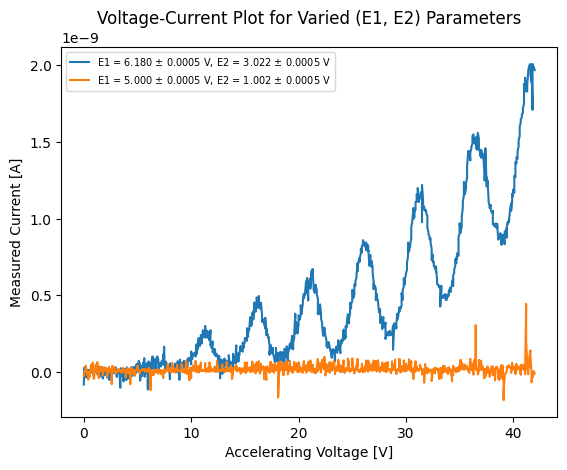

In [1573]:

def process_data(filename): #opens data and removes outliers
    data = open(filename, "r").readlines() #opens franck_hertz data file
    franck_hertz_voltages, franck_hertz_currents = [], [] #stores voltages and currents
    voltage_uncertainties, current_uncertainties = [], [] #stores uncertainties
    
    for line in data[1:]: #iterates through collected data
        line = line.split("\t") #splits individual measurements
        voltage, current = float(line[4]), float(line[2]) #extracts voltage and current measurements
        if float(line[4]) == 0:
            voltage_x = 0.00005 
        else:
            voltage_x = 0.5*(10**(math.floor(math.log10(voltage)) - 2))
        if float(line[2]) != 0:
            current_x =  0.5*(10**(math.floor(math.log10(abs(current))) - 2)) 
            #all values are known to 3 sig figs, this part adjusts the uncertainty based on that
        
        
        franck_hertz_voltages.append(voltage)
        franck_hertz_currents.append(current)
        voltage_uncertainties.append(voltage_x)
        current_uncertainties.append(current_x) #appens the voltage, current, and uncertainties to respective lists

    for i in range(0, len(franck_hertz_currents)): #iterates through current measurements
        if abs(franck_hertz_currents[i]) > 1: #identifies outliers
            neighbors = np.array([franck_hertz_currents[x] for x in range(i - 2, i + 2 + 1) if abs(franck_hertz_currents[x]) < 1])
            neighbors_uncertainties = np.array([current_uncertainties[x] for x in range(i - 2, i + 2 + 1) if abs(franck_hertz_currents[x]) < 1])
            franck_hertz_currents[i] = np.average(neighbors) #replaces outlier current measurements with average of adjacent measurements
            current_uncertainties[i] = np.average(neighbors_uncertainties) #replaces outlier current measurement uncertainty with average of adjacent measurement uncertainties

    franck_hertz_voltages, franck_hertz_currents = np.array(franck_hertz_voltages), np.array(franck_hertz_currents) 
    return franck_hertz_voltages[0:1000], franck_hertz_currents[0:1000], voltage_uncertainties[0:1000], current_uncertainties[0:1000]

franck_hertz_voltages, franck_hertz_currents, voltage_uncertainties, current_uncertainties = process_data("franck_hertz_data.txt") #processes data for E1 = 6.180, E2 = 3.022
franck_hertz_voltages_2, franck_hertz_currents_2, voltage_uncertainties2, current_uncertainties2 = process_data("franck_hertz_data_2.txt") #processes data for E1 = 5.000, E2 = 1.002

franck_hertz_voltages = unumpy.uarray(franck_hertz_voltages, voltage_uncertainties)
franck_hertz_currents = unumpy.uarray(franck_hertz_currents, current_uncertainties)

plt.figure(figsize=(6.4,4.8))
plt.plot([x.n for x in franck_hertz_voltages], [x.n for x in franck_hertz_currents], label="E1 = 6.180 $\pm$ 0.0005 V, E2 = 3.022 $\pm$ 0.0005 V")
plt.plot(franck_hertz_voltages_2, franck_hertz_currents_2, label="E1 = 5.000 $\pm$ 0.0005 V, E2 = 1.002 $\pm$ 0.0005 V") #plots voltage-current relationship for both sets of (E1, E2) parameters
plt.xlabel("Accelerating Voltage [V]")
plt.ylabel("Measured Current [A]")
plt.title("Voltage-Current Plot for Varied (E1, E2) Parameters")
plt.legend(loc='best', prop={'size': 7})
plt.show()

#### Part 1 - Finding Minima and Separation Between Minima

In this section, the minima of the voltage-current graph are determined, as well as the separation between them.

Though the graph above clearly has six distinct minima, it is not immediately clear what these minima are. To determine an estimate for the locations of these minima, the measurements are averaged with a particular window size. For example, if the window size was 5, measurements 1-5, 6-10, 11-15, etc. are averaged. 

At a window size of 9, minima of the graph are clearly visible. Moreover, 9 is the smallest window size at which the final 6 minima present in the graph are distinct - at lower window sizes, two of these minima are split into two separate minima. 

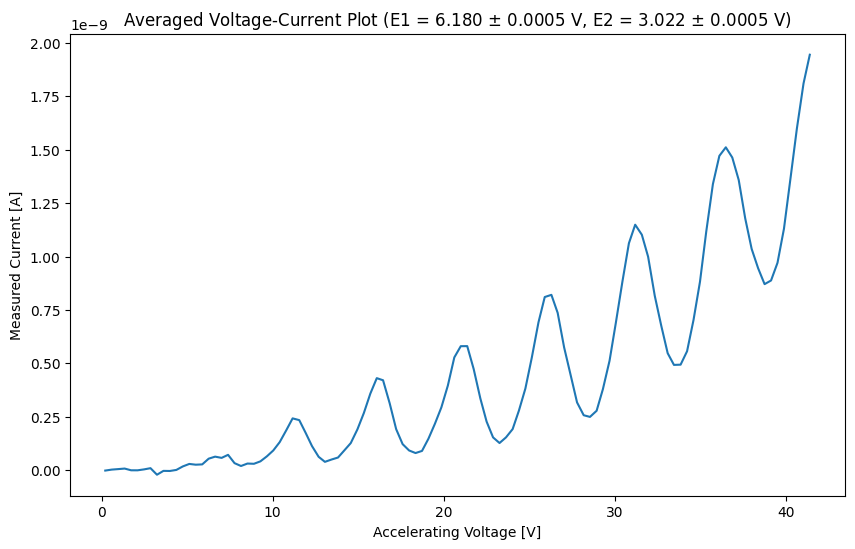

In [1574]:
franck_hertz_voltages_normalized = []
franck_hertz_currents_normalized = [] #store averaged voltages and currents
window_size = 9 #sets size of averaging windows

for i in range(1, len(franck_hertz_currents)-window_size, window_size):
    window_average_voltage = ufloat(sum([x.n for x in franck_hertz_voltages[i:i+window_size]])/window_size, sum([x.s for x in franck_hertz_voltages[i:i+window_size]])/window_size)
    window_average_current = ufloat(sum([x.n for x in franck_hertz_currents[i:i+window_size]])/window_size, sum([x.s for x in franck_hertz_currents[i:i+window_size]])/window_size)
    #calculates average voltage and current in each window
    
    franck_hertz_voltages_normalized.append(window_average_voltage) #appends averaged values to list
    franck_hertz_currents_normalized.append(window_average_current)
    
plt.figure(figsize=(10,6))
#plt.plot
plt.plot([x.n for x in franck_hertz_voltages_normalized], [x.n for x in franck_hertz_currents_normalized]) #plots averaged voltage vs. averaged current
plt.xlabel("Accelerating Voltage [V]")
plt.ylabel("Measured Current [A]")
plt.title("Averaged Voltage-Current Plot (E1 = 6.180 $\pm$ 0.0005 V, E2 = 3.022 $\pm$ 0.0005 V)")
plt.show()

Using a window_size of 9, all the averaged current data points that are less than there neighbors are found. there are several of these at voltage values less than 10V, but only 6, corresponding to the 6 minima, above 10V. Due to significant fluctuations and outliers in the raw data and the necessity of averaging it to determine the minima, the uncertainties are intentionally set to be large - the uncertainty of each minimum is set to be half of the largest of the differences between it one of its two neighbours. 

In [1575]:
voltage_minima, current_minima = [],[] #stores minima
for i in range(0, len(franck_hertz_currents_normalized)-1): #iterates through averaged measurements
    if (franck_hertz_currents_normalized[i] < franck_hertz_currents_normalized[i-1]) & (franck_hertz_currents_normalized[i] < franck_hertz_currents_normalized[i+1]): #if a averaged curernt measurement is less than both of its neighbours
        
        min_voltage_x_1 = ufloat((franck_hertz_voltages_normalized[i].n - franck_hertz_voltages_normalized[i-1].n), (franck_hertz_voltages_normalized[i].s + franck_hertz_voltages_normalized[i-1].s)) 
        #calculates difference between minimum and the measurement immediately before it
        min_voltage_x_2 = ufloat((franck_hertz_voltages_normalized[i+1].n - franck_hertz_voltages_normalized[i].n), (franck_hertz_voltages_normalized[i].s + franck_hertz_voltages_normalized[i+1].s))
        #calculates difference between minimum and the measurement immediately after it
        min_voltage_x = 0.5*max(min_voltage_x_1, min_voltage_x_2) #takes half of the larger of the two differences to be the uncertainty
        
        #does the same as above, but for the current
        min_current_x_1 = ufloat((franck_hertz_currents_normalized[i].n - franck_hertz_currents_normalized[i-1].n), (franck_hertz_currents_normalized[i].s + franck_hertz_currents_normalized[i-1].s))
        min_current_x_2 = ufloat((franck_hertz_currents_normalized[i+1].n - franck_hertz_currents_normalized[i].n), (franck_hertz_currents_normalized[i].s + franck_hertz_currents_normalized[i+1].s))
        min_current_x = 0.5*max(min_current_x_1, min_current_x_2)
        
        #appends to respective lists
        voltage_minima.append(ufloat(franck_hertz_voltages_normalized[i].n, min_voltage_x.n))
        current_minima.append(ufloat(franck_hertz_currents_normalized[i].n, min_current_x.n))

voltage_minima = unumpy.uarray([x.n for x in voltage_minima], [x.s for x in voltage_minima])
current_minima = unumpy.uarray([x.n for x in current_minima], [x.s for x in current_minima])

voltage_minima_arr = np.expand_dims(voltage_minima, 0)
current_minima_arr = np.expand_dims(current_minima, 0)

output_minima = np.array([current_minima_arr, voltage_minima_arr]).squeeze(1).transpose()
print(pd.DataFrame(output_minima[8:], columns=["Minimum Current [A]", "Corresponding Voltage [V]"])) #displays minima in table

   Minimum Current [A] Corresponding Voltage [V]
0      (3.9+/-0.5)e-11              13.06+/-0.19
1      (8.0+/-0.5)e-11              18.36+/-0.19
2    (1.27+/-0.13)e-10              23.27+/-0.19
3    (2.49+/-0.14)e-10              28.56+/-0.19
4  (4.928+/-0.006)e-10              33.47+/-0.19
5    (8.71+/-0.08)e-10              38.77+/-0.19


This gives a set of six voltage measurements for the minima. However, from Fig. 1, it is clear that the electrometer reading for the voltage is made *after* the fixed voltage E4 is applied to the electrons. Therefore, the true values of the minima, in terms of the accelerating voltage, are the sums of the measured minima with the E4 voltage. The exact value of this voltage was not provided in the experiment apparatus - however, the expected transition energy for mercury can still be determined from the separation between the 

In [1576]:
voltage_separations = unumpy.uarray([voltage_minima[i].n - voltage_minima[i-1].n for i in range(1, len(voltage_minima))], 
                                    [voltage_minima[i].s + voltage_minima[i-1].s for i in range(1, len(voltage_minima))])
current_separations = unumpy.uarray([current_minima[i].n - current_minima[i-1].n for i in range(1, len(current_minima))], 
                                    [current_minima[i].s + current_minima[i-1].s for i in range(1, len(current_minima))]) 
#calculates separations between each of the minima


voltage_separations_arr = np.expand_dims(voltage_separations, 0)
current_separations_arr = np.expand_dims(current_separations, 0)

output_separations = np.array([current_separations_arr, voltage_separations_arr]).squeeze(1).transpose()
print(pd.DataFrame(output_separations[8:], columns=["Current Separation Between Minima [A]", "Voltage Separation Between Minima [V]"]))
#displays the separations in a table

average_separation = ufloat(sum([x.n for x in (voltage_separations[8:])])/len(voltage_separations[8:]), sum([x.s for x in (voltage_separations[8:])])/len(voltage_separations[8:]))
print("\nAverage Separation: ", f'{average_separation:.2f}')
#calculates and outputs the average separation between minima

  Current Separation Between Minima [A] Voltage Separation Between Minima [V]
0                       (4.1+/-1.0)e-11                             5.3+/-0.4
1                       (4.7+/-1.8)e-11                             4.9+/-0.4
2                     (1.22+/-0.28)e-10                             5.3+/-0.4
3                     (2.43+/-0.15)e-10                             4.9+/-0.4
4                     (3.78+/-0.09)e-10                             5.3+/-0.4

Average Separation:  5.14+/-0.38


#### Part 3 - Final Calculations and Conclusions

The average measured separation between minima is $5.14 \pm 0.38$. Varying the window size produces slightly different results, but all are within the uncertainty range. Shifting the windows to the right or left also consistently produces values within the uncertainty range. 

A separation of $5.14 \pm 0.34$ V indicates that the energy required to excite a mercury atom is $(5.14 \pm 0.38)$ eV  (i.e. the additional energy the electron gains between minima). The photons emitted by this transition should follow the below equation:

#### $\lambda _{transition} = \frac{hc}{E_{transition}}$ #####

Using the generally accepted values for $h$ and $c$, 

In [1577]:
lambda_transition = (planck_const*speed_light)/(average_separation*ev_to_joules) 
#calculates the photon wavelength corresponsing to the calculated transition energy.
print(lambda_transition) #outputs wavelength

(2.41+/-0.18)e-07


Therefore, the emitted light should have a wavelength of $241 \pm 18$ nm. 

Comparing these values to the accepted values of $4.86$ eV for the transition energy and $255$ nm for the emitted light, both are within the experimental uncertainty range. Therefore, the experiment is consistent with the expected behaviour of mercury atoms and with the quantized model of the atomic energy levels. 